# Static traffic assignment iPython code
*** 
- [Section 1](#graph) upload the graph
- [Section 2](#demand) upload the demand
- [Section 3](#assignment) encode the all or nothing function

***
We want to solve the following problem (TAP):
\begin{align}
\min_{h} &\sum_{a} \int_{0}^{f_a} c_a(s)\; \text{d}s
\\
\text{s.t.  } & \;\; f = \Delta h
\\
& \;\; 
h \geq 0
\\
& \;\; 
A h = d
\end{align}

## 1. Read of the tntp net (graph) <a id="graph"></a>
***
The file are used from https://github.com/bstabler/TransportationNetworks.

_Maybe we can use the metadata._

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt

def read_metadata(file):
    """
    Parameter: 
        file: a string which represent the path to the data file tntp.
    Return:
        The function read the first metadata lines (in the <> tag) and return the numbers of lines read.
    """
    inputfile = open(file)
    line = inputfile.readline()
    line_skip = 0
    # parsing metadata
    while "<" in line:
        line_skip += 1
        # print(line, end="")
        line = inputfile.readline()
    """   
    # skip all the blank line
    while len(line)<2:
        line_skip += 1
        line = inputfile.readline()
    """ 
    return line_skip
    # print(line)
    # return line, line_skip

def read_data(file, line_skip):
    """
    Parameter: 
        file: a string which represent the path to the data file tntp
        line_skip: the number of lines of metadata to skip (should be the output of read_metadata(file))
    Return:
        The function read the tntp file using pandas.
        It drops the columns ~ and ;
        Then it return the legend and the data in a np.array
    """
    table = pd.read_csv(file, sep='\t', header=line_skip)
    
    # remove columns with ~ or ;
    to_remove = set({})
    for i in range(table.columns.shape[0]):
        if '~' in table.columns[i] or ';' in table.columns[i]:
            # print(i)
            to_remove.add(i)
    table = table.drop(table.columns[list(to_remove)], axis=1)
    
    # HERE we should do some data type change (init node, term node and power should be 32 bit integer)
    legend = np.array(table.columns)
    table_tmp = np.array(table)
    del table
    # get the legend and the data with np
    return legend, table_tmp

def init_travel_time_function(network):
    """
    Parameter: 
        network: a string which represent the path to the data file tntp
    Return:
        The table that can be used to compute the travel time of every links.
        The index of the free flow travel time, of the B, of the capacity and of the power columns.
        
        The travel time of a link (one row of the table) is t(f) = t0 * (1 + B*(f/capacity)**power)
    """
    file_type = "net"
    suffix = "_" + file_type + ".tntp"
    line_skip = read_metadata(network + suffix)
    legend_net, table_net = read_data(network + suffix, line_skip)
    
    j = 0
    for legend_name in legend_net:
        # print(legend_name)
        if "B" in legend_name:
            index_B = j
        if "Power" in legend_name:
            index_power = j
        if "Free Flow Time" in legend_name:
            index_fft = j
        if "Capacity" in legend_name:
            index_capacity = j
        if "Init" in legend_name:
            index_init = j
        if "Term" in legend_name:
            index_term = j
        j += 1
    graph_wrapped = table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term
    return graph_wrapped


def travel_time(flow, graph_wrapped):
    """
    Parameter: 
        flow: a vector that represents the flow of every links
        graph_wrapped: should be = (table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term)
    Return:
        A travel time vector for every links given the flow allocation flow.
        
        The travel time of a link (one row of the table) is t(f) = t0 * (1 + B*(f/capacity)**power)
    """
    table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term = graph_wrapped
    return table_net[:,index_fft] * (1 + table_net[:,index_B]*(flow/table_net[:,index_capacity])**table_net[:,index_power])

def flow_cost_solution(network):
    """
    Read and return the flow and the cost of the STA solution using the flow.tntp file
    """
    file_type = "flow"
    suffix = "_" + file_type + ".tntp"
    line_skip = read_metadata(network + suffix)
    legend_flow, table_flow = read_data(network + suffix, line_skip)
    j = 0
    for legend_name in legend_flow:
        if "Volume" in legend_name:
            index_flow = j
        if "Cost" in legend_name:
            index_cost = j
        j += 1

    flow = table_flow[:,index_flow]
    cost_solution = table_flow[:,index_cost]
    return flow, cost_solution

def test_travel_time_function(network, graph):
    """
    Parameter:
        file: a string which represent the path to the data file tntp
    Using the flow.tntp file (solutions) and the travel time function,
    the function tests if travel_time(flow_solutions) == cost_solutions
    Return:
        A vector of the differences between travel_time(flow_solutions) and cost_solutions for every links
    """
    flow, cost_solution = flow_cost_solution(network)
    print(np.linalg.norm(travel_time(flow, graph) - cost_solution))
    return travel_time(flow, graph) - cost_solution

In [2]:
# test if our travel_time function is correct
network = 'Traffic_network_framework/data/SiouxFalls/SiouxFalls'
graph_wrapped = init_travel_time_function(network)
test_travel_time_function(network, graph_wrapped)

# network = 'data/Anaheim/Anaheim'
# table_net, index_fft, index_B, index_capacity, index_power = init_travel_time_function(network)
# test_travel_time_function(network)

"""
network = 'data/Eastern-Massachusetts/EMA'
table_net, index_fft, index_B, index_capacity, index_power = init_travel_time_function(network)
test_travel_time_function(network)

network = 'data/Berlin-Tiergarten/berlin-tiergarten'
table_net, index_fft, index_B, index_capacity, index_power = init_travel_time_function(network)
test_travel_time_function(network)
"""

print()

3.277847697668423e-14



## 2. Read of the trips tntp (demand) file <a id="demand"></a>
***

In [3]:
def read_demand(network):
    """
    Parameter: 
        file: a file name that encode the demand under a TNTP format (network_trips.tntp).
    Return:
        A dictionary of keys based sparse matrix encoding the demand.
    """
    file_type = "trips"
    file = network + "_" + file_type + ".tntp"
    inputfile = open(file)
    line = inputfile.readline()
    # parsing metadata
    while "<" in line:
        print(line, end="")
        line = inputfile.readline()

    # skip all the blank line
    while len(line)<2:
        line = inputfile.readline()

    # read the Origin
    assert 'Origin' in line
    data = {}
    # print(line, end="")
    origin = int(line.split('\t')[1])
    data[origin] = {}
    for line in inputfile:
        # print(line, end="")
        if 'Origin ' in line:
            origin = int(line.split('\t')[1])
            data[origin] = {}
        # else read the destination
        else:
            dest_array = line.split(";")
            for dest in dest_array[:-1]:
                dest_tmp = dest.split(":")
                data[origin][int(dest_tmp[0])] = float(dest_tmp[1])

    d = pd.DataFrame(data)
    del data

    demand = sparse.csr_matrix(np.array(d))
    del d
    # print(demand)
    return demand.todok()

## Useful functions <a id="useful"></a>
***
- `init_travel_time_function(network_name : String) : graph_wrapped` gives a graph wrapped = (table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term) from the name of the data (like __data/SiouxFalls/SiouxFalls__)
- `travel_time(flow, graph_wrapped)` gives the travel time vector for every link given the graph_wrapped (c.f. init_travel_time_function) and the vector of link flow
- `read_demand(file)` gives a sparse matrix representing the demand
- `get_graph(graph_wrapped) : dict` returns a dictionary encoding the graph from the graph wrapped

## Test functions
***
- `test_travel_time_function(network, graph)` tests if travel_time gives the correct cost when the optimal flow allocation is given in the data (like in __data/SiouxFalls/SiouxFalls__)

## 3. Assignment <a id="assignment"></a>
***

[Useful function](#useful)

In [4]:
def get_graph(graph_wrapped):
    """
    Parameter:
        graph_wrapped: should be = (table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term)
    Return:
        A dictionary encoding the graph: graph[origin][destination] = link_id
    """
    table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term = graph_wrapped
    
    graph = {}
    for i in range(table_net.shape[0]):
        link_index = i
        node_init = int(table_net[i][index_init])
        node_term = int(table_net[i][index_term])
        
        if node_init not in graph:
            graph[node_init] = {}
        # if node_term not in graph[node_init]:
        #     graph[node_init][node_term] = {}
        # we assume that there is only one possible directed link between two nodes
        graph[node_init][node_term] = link_index
    return graph

def initialization(network):
    """
    Parameter:
        network: the file name of the data 
    Return:
        graph_wrapped, demand, graph, nb_links using previously defined functions
    """
    graph_wrapped = init_travel_time_function(network)
    demand = read_demand(network)
    graph = get_graph(graph_wrapped)

    table_net, _, _, _, _, _, _ = graph_wrapped
    nb_links = table_net.shape[0]
    return graph_wrapped, demand, graph, nb_links

# we have the demand in the sparse matrix demand, and the travel_time function in travel_time
# we have the graph of the network in graph


In [5]:
def neighbours(node, adj):
    """
    Parameter:
        node: node for which to find neigbours for
        adj: adjacency matrix that describes network
    Return:
        List of nodes that are neighbours to node
    """
    return np.nonzero(adj[node])[0].tolist()

def add_flow_dijkstra(adj, src, target, faon, flow, g):
    """
    Parameter:
        adj: adjacency matrix that describes network
        src: starting node for OD pair
        target: end node for OD pair
        faon: current all or nothing flow allocation that the algorithm is building
        flow: demand of the current of OD pair
        g: graph dictionary, g[node_init] = {node_term_1: link_from_init_to_term_1, node_term_2: link_from_init_to_term_2}
    Return:
        Returns all or nothing flow allocation, where flow is allocated by shortest path for OD pair (as determined by Dijkstra's algorithm)
    """
    q = [i for i in range(len(adj))] # queue of nodes
    dist = [np.inf for i in range(len(adj))] # node distances
    prev = [None for i in range(len(adj))] # predecessor in shortest path
    
    dist[src] = 0 # set source node's distance to itself as zero
    
    while len(q) != 0:
        u = min(q, key=lambda n:dist[n])
        q.remove(u)
        
        if u == target: # when target is reach, use predecessors to allocate all or nothing flow to links in shortest path
            while u != src:
                prev_node = prev[u]
                curr_link = g[prev_node+1][u+1]
                faon[curr_link] += flow
                u = prev_node
            return faon
        
        for v in neighbours(u, adj):
            alt = dist[u] + adj[u][v]
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u



In [18]:
import scipy
from scipy.sparse.csgraph import dijkstra

def update_travel_time_from_tt(graph, tt):
    nb_nodes = len(graph)
    G = np.zeros(shape=(nb_nodes,nb_nodes))
    G = scipy.sparse.lil_matrix(G)
    for i in graph.keys():
        for j in graph[i].keys():
            G[i-1, j-1] = tt[graph[i][j]] # THIS IS VERY BAD BECAUSE I PUT i-1 and j-1 instead of i and j
    G = G.tocsr()
    return G

def put_on_shortest_path(faon, o_tmp, d_tmp, flow_tmp, tt, g, G):
    """
    Parameter:
        faon: current all or nothing flow allocation that the algorithm is building
        o_tmp: origin of the current od pair
        d_tmp: destination of the current od pair
        flow_tmp: demand of the current of pair
        tt: travel time on every links, tt[l] = travel time of the link l
        g: graph dictionary, g[node_init] = {node_term_1: link_from_init_to_term_1, node_term_2: link_from_init_to_term_2}
    Return:
        TO WRITE
    """
    dist_matrix, return_predecessors = dijkstra(G, return_predecessors = True) # change
    
    node_tmp = d_tmp
    # using the dijkstra, we build the fastest path and we put the flow on it.
    while node_tmp != o_tmp:
        node_tmp_d = return_predecessors[o_tmp][node_tmp]
        # Here we need the graph_dict to recover the link id from the nodes id.
        link_tmp = g[node_tmp_d+1][node_tmp+1] # this is very bad because we use node_tmp +1 and node_tmp_d + 1 instead of node_tmp and node_tmp_d
        faon[link_tmp] += flow_tmp
        node_tmp = node_tmp_d

    return faon

# all or nothing function
def all_or_nothing(d, tt, g):
    """
    Parameter:
        d: a demand as sparse matrix, d[origin][dest] = demand between origin and dest
        tt: travel time on every links, tt[l] = travel time of the link l
        g: graph dictionary, g[node_init] = {node_term_1: link_from_init_to_term_1, node_term_2: link_from_init_to_term_2}
    Return:
        The all or nothing flow allocation corresponding to the demand d and the travel time tt.
    """
    nb_links = tt.shape
    faon = np.zeros(nb_links)
    
    G = update_travel_time_from_tt(g, tt) # to remove for putting the dijkstra algorithm
    adj = G.toarray()
    
    for o_tmp, d_tmp in d.keys():
        #sp = find_sp(o_tmp, d_tmp)
        #faon = add_flow(faon, sp, d[o_tmp, d_tmp])
        faon = add_flow_dijkstra(adj, o_tmp, d_tmp, faon, d[o_tmp, d_tmp], g)
        # flow_tmp = d[o_tmp, d_tmp]
        # faon = put_on_shortest_path(faon, o_tmp, d_tmp, flow_tmp, tt, g, G) # to change when we write our own 
    return faon

#def find_sp(g):

def potential(f, graph_wrapped):
    """
    Parameter:
        flow: a vector that represents the flow of every links
        graph_wrapped: should be = (table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term)
    Return:
        The potential function tha t we want to minimize.
        
        The potential function is (one row of the table) is sum(int(t_e(s), s in [0, f_e]), e) = sum(t0 * (f + B*(f/capacity)**(power+1)/power)).    
        This function is useful for doing a line search, it computes the potential at flow assignment f.
    """
    table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term = graph_wrapped
    pot_tmp = table_net[:,index_fft] * f * (1 + (table_net[:,index_B] / table_net[:,index_power])*(f/table_net[:,index_capacity])**table_net[:,index_power])
    return np.sum(pot_tmp)

def line_search(f, res=20):
    """
    Parameter:
        f: the function that we want to minimize between 0 and 1
        res: the resolution of the grid ([0, 1] is divided in 2^res points).
    Return:
        On a grid of 2^res points bw 0 and 1, find global minimum for a continuous convex function using bisection 
    """
    d = 1. / (2**res - 1) # d: Size of interval between adjacent points
    l, r = 0, 2**res - 1 # l: first point, r: last point
    while r - l > 1:
        if f(l * d) <= f(l * d + d): # Interval l: [l*d, l*d + d]
            return l * d
        if f(r * d - d) >= f(r * d):
            return r * d
        # otherwise f(l) > f(l+d) and f(r-d) < f(r)
        m1, m2 = (l + r) / 2, 1 + (l + r) / 2
        if f(m1 * d) < f(m2 * d):
            r = m1
        if f(m1 * d) > f(m2 * d):
            l = m2
        if f(m1 * d) == f(m2 * d):
            return m1 * d
    return l * d

# write pseudocode STA
epsilon = 0.0000001

# initialization
network = 'Traffic_network_framework/data/SiouxFalls/SiouxFalls'
graph_wrapped, demand, graph, nb_links = initialization(network)

table_net, _, _, _, _, _, _ = graph_wrapped
nb_links = table_net.shape[0]


f = all_or_nothing(demand, travel_time(np.zeros(nb_links), graph_wrapped), graph)
f_iter = []
tt_iter = []

alpha = 1.0
i = 0
while alpha>epsilon and i<1000:
    f_iter.append(f)
    tt = travel_time(f, graph_wrapped)
    faon = all_or_nothing(demand, tt, graph)
    tt_iter.append(np.dot(tt,(f - faon)))
    alpha = line_search(lambda a : potential((1. - a) * f + a * faon, graph_wrapped))
    f = (1-alpha) * f + alpha * faon
    i = i+1
print(i)
print(f)

<NUMBER OF ZONES> 24
<TOTAL OD FLOW> 360600.0
<END OF METADATA>
84
[ 4606.33651558  8089.24179982  4492.45685473  6069.66170996
  8203.12146067 14157.36592879 10206.93896357 14234.27215949
 18159.21591642  5478.2395269  18239.67328829  8707.78359598
 15911.35392947  5955.78204911  8765.44897257 12524.94447302
 12114.89384843 15794.97185659 12468.73018877 12183.19143094
  6918.46080546  8371.25453716 15934.14592474  6917.98791968
 21824.84808751 21747.167197   17597.10270999 23199.46467902
 11070.57934957  8103.7693095   5374.68838574 17707.49199041
  8419.84569591  9824.71405286 10243.91239372  8370.37728107
 12662.42608466 12549.93109997 11102.74423808  9781.02060694
  9101.13169869  8371.94391073 23131.81196285  9041.35332316
 19118.83968547 18313.13914503  8383.8107212  11048.92587201
 11592.672979   15452.62532593  8105.0053323  11609.46654853
  9919.844884   15726.67427408 15426.73446288 19125.41508411
 19064.85476292  9937.87447633  8694.86678579 19131.22663855
  8658.91145556  6

In [19]:
flow, cost = flow_cost_solution(network)
print(flow)

[ 4494.65764646  8119.07994805  4519.07994805  5967.33639617
  8094.65764646 14006.37101986 10022.31961516 14030.5609174
 18006.37101986  5200.         18030.5609174   8798.26771411
 15780.78205547  5991.75869776  8806.49866681 12492.92536056
 12101.52912231 15794.01060698 12525.57861486 12040.91827285
  6882.66491266  8388.713063   15796.7410003   6836.70597529
 21744.07608018 21814.07608764 17726.62503296 23125.7972901
 11047.09388127  8100.          5300.         17604.22353323
  8365.28565386  9776.11953275  9973.70741603  8404.93462395
 12287.60526902 12378.64203998 11121.35796002  9814.06906293
  9036.33413403  8400.43683027 23192.28335936  9079.82031659
 19083.28976475 18409.93502652  8406.71440521 11073.00931921
 11695.00291653 15278.32524152  8100.         11683.83828244
  9953.02143205 15854.62145644 15333.40665575 18976.7961192
 19116.72427908  9941.85679796  8688.36704049 18992.4883829
  8710.63692073  6302.02287419  7000.          6239.98501812
  8619.5396981  10309.410803

In [20]:
print(potential(flow, graph_wrapped))
print(potential(f, graph_wrapped))
print(np.linalg.norm(f-flow)/np.linalg.norm(flow))

4434390.915720795
4442718.63371744
0.008464608808146618


In [21]:
print("Graph")
print(graph)
print("Travel time")
print(travel_time(flow, graph_wrapped))
print("Demand")
print(demand)

Graph
{1: {2: 0, 3: 1}, 2: {1: 2, 6: 3}, 3: {1: 4, 4: 5, 12: 6}, 4: {3: 7, 5: 8, 11: 9}, 5: {4: 10, 6: 11, 9: 12}, 6: {2: 13, 5: 14, 8: 15}, 7: {8: 16, 18: 17}, 8: {6: 18, 7: 19, 9: 20, 16: 21}, 9: {5: 22, 8: 23, 10: 24}, 10: {9: 25, 11: 26, 15: 27, 16: 28, 17: 29}, 11: {4: 30, 10: 31, 12: 32, 14: 33}, 12: {3: 34, 11: 35, 13: 36}, 13: {12: 37, 24: 38}, 14: {11: 39, 15: 40, 23: 41}, 15: {10: 42, 14: 43, 19: 44, 22: 45}, 16: {8: 46, 10: 47, 17: 48, 18: 49}, 17: {10: 50, 16: 51, 19: 52}, 18: {7: 53, 16: 54, 20: 55}, 19: {15: 56, 17: 57, 20: 58}, 20: {18: 59, 19: 60, 21: 61, 22: 62}, 21: {20: 63, 22: 64, 24: 65}, 22: {15: 66, 20: 67, 21: 68, 23: 69}, 23: {14: 70, 22: 71, 24: 72}, 24: {13: 73, 21: 74, 23: 75}}
Travel time
[ 6.00081624  4.00869075  6.00083412  6.57359826  4.00858665  4.26940183
  4.02017916  4.27126776  2.31537411  7.13330048  2.31707223  9.99822521
  9.65131071  6.59951767 10.02070256 14.690955    5.55216038  2.06222569
 14.82415952  5.50141296 15.17470751 10.72947353  9.67

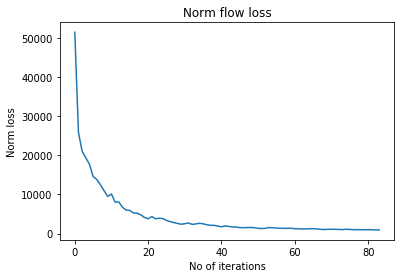

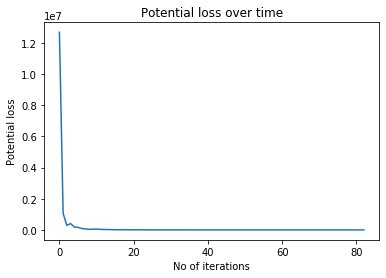

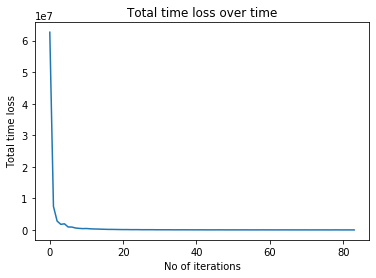

In [22]:
norm_flow_loss = [np.linalg.norm(f-flow,2) for f in f_iter]
plt.figure()
plt.title("Norm flow loss")
plt.ylabel("Norm loss")
plt.xlabel("No of iterations")
plt.plot(norm_flow_loss)
plt.show()

potential_loss = [potential(f_iter[i], graph_wrapped)-potential(f_iter[i+1], graph_wrapped) for i in range(len(f_iter)-1)]
plt.figure()
plt.title("Potential loss over time")
plt.ylabel("Potential loss")
plt.xlabel("No of iterations")
plt.plot(potential_loss)
plt.show()

plt.figure()
plt.title("Total time loss over time")
plt.ylabel("Total time loss")
plt.xlabel("No of iterations")
plt.plot(tt_iter)
plt.show()